# Import the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Read the data

In [ ]:
df = pd.read_csv("phishing_site_urls.csv")
print(df.shape)
df.head()

(549346, 2)


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [ ]:
df.Label.value_counts()

good    392924
bad     156422
Name: Label, dtype: int64

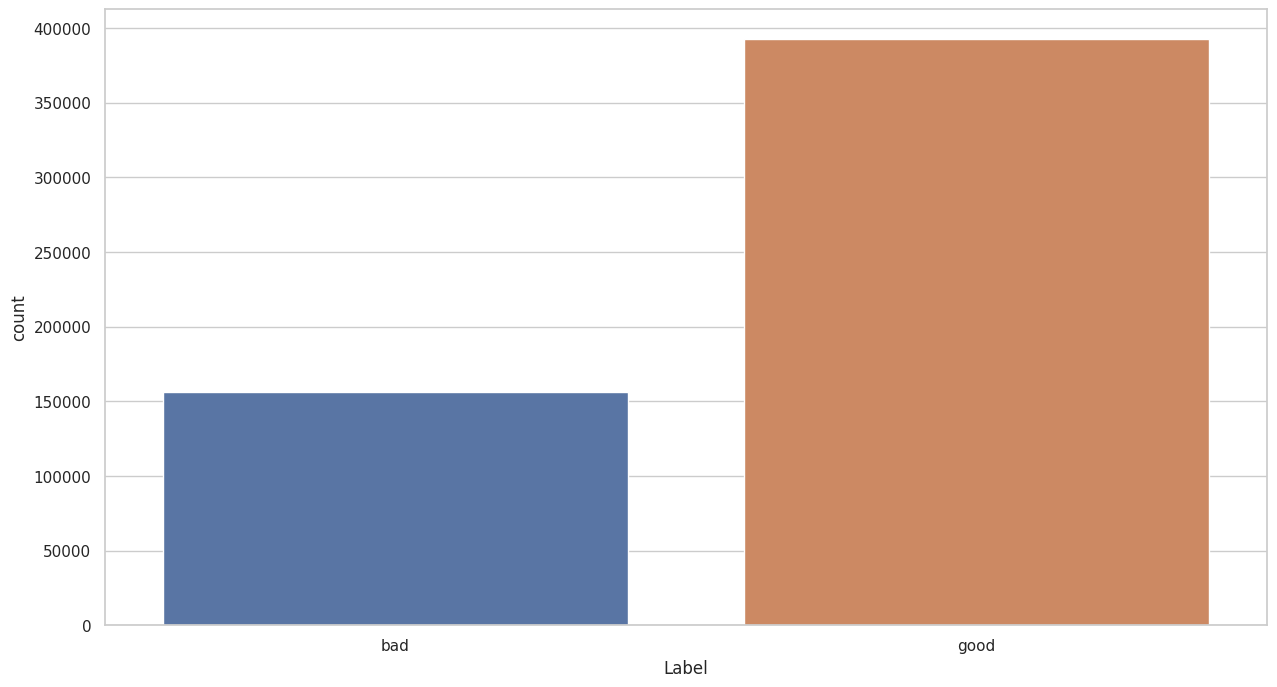

In [ ]:
sns.countplot(data=df, x="Label")
plt.show()

# Shuffle the data

In [ ]:
df_shuffled = shuffle(df, random_state=42)

# Choose 5000 samples

In [ ]:
data_size = 5000

In [ ]:
df_used = df_shuffled[:data_size].copy()

# Make sure the distribution is the same after taking the sample

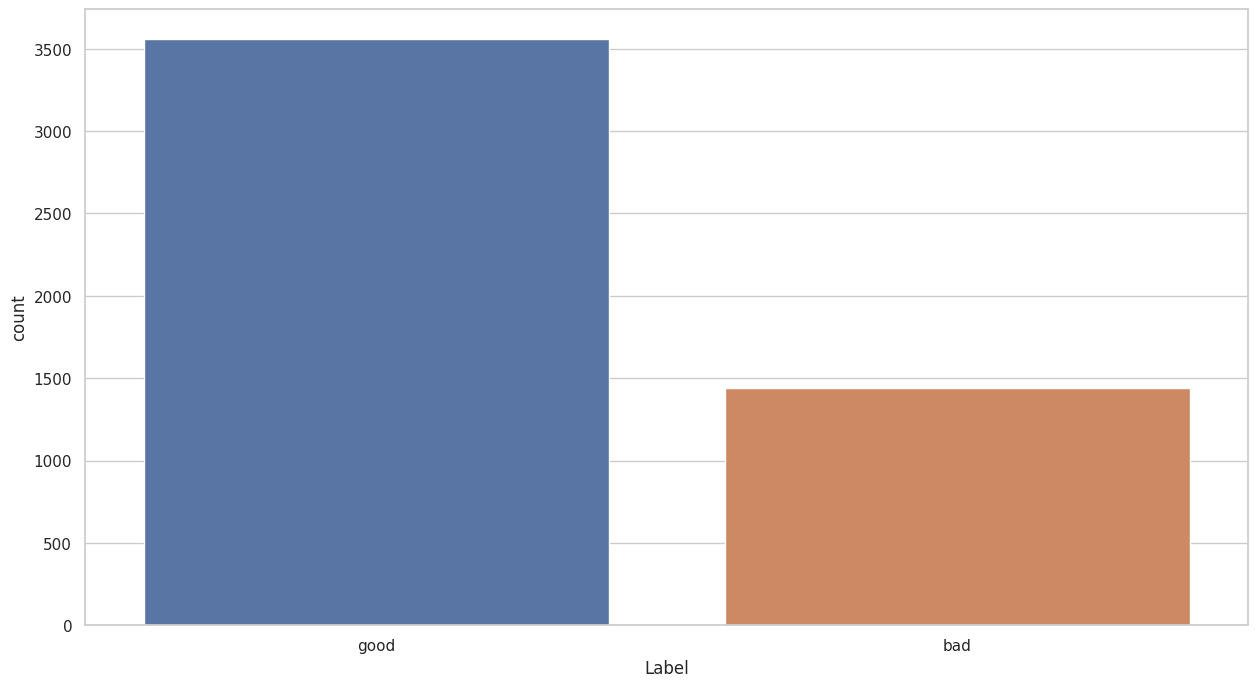

In [ ]:
sns.countplot(data=df_used, x="Label")
plt.show()

In [ ]:
df_used.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 452638 to 170545
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URL     5000 non-null   object
 1   Label   5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


# Replace the labels

In [ ]:
df_used.replace({'good':0, 'bad':1}, inplace=True)

In [ ]:
df_used.Label.value_counts()

0    3562
1    1438
Name: Label, dtype: int64

# Divide the data into features and labels

In [ ]:
X = df_used[['URL']].copy()
y = df_used.Label.copy()

# Initialize the tokenizer, stemmer, and Vectorizer

In [ ]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = SnowballStemmer("english")
cv = CountVectorizer()

# Prepare the data

In [ ]:
def prepare_data(X) :
    X['text_tokenized'] = X.URL.map(lambda t: tokenizer.tokenize(t))
    X['text_stemmed'] = X.text_tokenized.map(lambda t: [stemmer.stem(word) for word in t])
    X['text_sent'] = X.text_stemmed.map(lambda t: ' '.join(t))
    features = cv.fit_transform(X.text_sent)
    return X, features

In [ ]:
X, features = prepare_data(X)

# Import and intitialize the models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svc = SVC()

In [ ]:


xgb = XGBClassifier()


# Train and test the models using different training percentages

In [ ]:
def train_test_model(model, X, y, training_percentage) :
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=1-training_percentage, stratify=y, random_state=42)
    model.fit(trainX, trainY)
    predY = model.predict(testX)
    accuracy = accuracy_score(testY, predY)
    precision = precision_score(testY, predY, pos_label=1)
    recall = recall_score(testY, predY, pos_label=1)
    return accuracy, precision, recall

In [ ]:
training_sizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
def model_results(model) :
    results = []
    for p in training_sizes :
        results.append(train_test_model(model, features, y, p))
    return pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall'])

In [ ]:
logreg_results = model_results(logreg)
knn_results = model_results(knn)
dtree_results = model_results(dtree)
rfc_results = model_results(rfc)
svc_results = model_results(svc)
xgb_results = model_results(xgb)

In [ ]:
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'SVM', 'XGBoost']
model_results = [logreg_results, knn_results, dtree_results, rfc_results, svc_results, xgb_results]

In [ ]:
accuracies = []
precisions = []
recalls = []
for model in model_results :
    accuracies.append(model.Accuracy.values)
    precisions.append(model.Precision.values)
    recalls.append(model.Recall.values)

In [ ]:
accuracies = pd.DataFrame(np.transpose(accuracies), columns=models, index=training_sizes*100)
precisions = pd.DataFrame(np.transpose(precisions), columns=models, index=training_sizes*100)
recalls = pd.DataFrame(np.transpose(recalls), columns=models, index=training_sizes*100)

In [ ]:
accuracies

,Logistic Regression,KNN,Decision Tree,Random Forest,SVM,XGBoost
10.0,0.830667,0.739778,0.819778,0.838889,0.783111,0.828889
20.0,0.863500,0.727750,0.849750,0.870000,0.832750,0.855000
30.0,0.881429,0.726286,0.854857,0.881143,0.847143,0.864000
40.0,0.885667,0.736000,0.860333,0.886000,0.856333,0.877000
50.0,0.892400,0.750800,0.866800,0.898800,0.864400,0.880800
60.0,0.900500,0.750000,0.874000,0.897000,0.872500,0.889000
70.0,0.909394,0.765490,0.873418,0.897402,0.880746,0.892072
80.0,0.902000,0.742000,0.881000,0.889000,0.878000,0.885000
90.0,0.896000,0.738000,0.874000,0.888000,0.872000,0.880000


In [ ]:
precisions

,Logistic Regression,KNN,Decision Tree,Random Forest,SVM,XGBoost
10.0,0.915625,0.557423,0.787843,0.889193,0.954286,0.770661
20.0,0.914835,0.526091,0.835165,0.915567,0.925664,0.826835
30.0,0.920455,0.521548,0.829590,0.912134,0.918440,0.839949
40.0,0.901235,0.538883,0.819885,0.916800,0.892727,0.852857
50.0,0.894737,0.564000,0.819536,0.944656,0.889344,0.872566
60.0,0.917778,0.560976,0.832990,0.940334,0.937158,0.881210
70.0,0.930233,0.590498,0.827027,0.942675,0.937716,0.894737
80.0,0.916667,0.546296,0.821293,0.919431,0.932292,0.871245
90.0,0.933962,0.538922,0.846154,0.931373,0.925532,0.896226


from matplotlib import pyplot as plt
precisions['Logistic Regression'].plot(kind='hist', bins=20, title='Logistic Regression')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precisions['KNN'].plot(kind='hist', bins=20, title='KNN')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precisions['Decision Tree'].plot(kind='hist', bins=20, title='Decision Tree')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precisions['Random Forest'].plot(kind='hist', bins=20, title='Random Forest')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precisions.plot(kind='scatter', x='Logistic Regression', y='KNN', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precisions.plot(kind='scatter', x='KNN', y='Decision Tree', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precisions.plot(kind='scatter', x='Decision Tree', y='Random Forest', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precisions.plot(kind='scatter', x='Random Forest', y='SVM', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
precisions['Logistic Regression'].plot(kind='line', figsize=(8, 4), title='Logistic Regression')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
precisions['KNN'].plot(kind='line', figsize=(8, 4), title='KNN')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
precisions['Decision Tree'].plot(kind='line', figsize=(8, 4), title='Decision Tree')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
precisions['Random Forest'].plot(kind='line', figsize=(8, 4), title='Random Forest')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
recalls

,Logistic Regression,KNN,Decision Tree,Random Forest,SVM,XGBoost
10.0,0.452859,0.461360,0.510819,0.502318,0.258114,0.576507
20.0,0.579130,0.534783,0.594783,0.603478,0.454783,0.626957
30.0,0.643496,0.588878,0.623635,0.649454,0.514399,0.651440
40.0,0.676709,0.570104,0.659328,0.663963,0.568946,0.691773
50.0,0.709318,0.588317,0.688456,0.688456,0.603616,0.685675
60.0,0.718261,0.600000,0.702609,0.685217,0.596522,0.709565
70.0,0.740741,0.604167,0.708333,0.685185,0.627315,0.708333
80.0,0.725694,0.614583,0.750000,0.673611,0.621528,0.704861
90.0,0.687500,0.625000,0.687500,0.659722,0.604167,0.659722


# Plot the accuracy, precision, and recall of the 5 models

<ipython-input-93-81f20a7f04a9>:3: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  g = sns.lineplot(data = accuracies, markers= ['o', 'o', 'o', 'o', 'o'])


Text(0, 0.5, 'Accuracy')

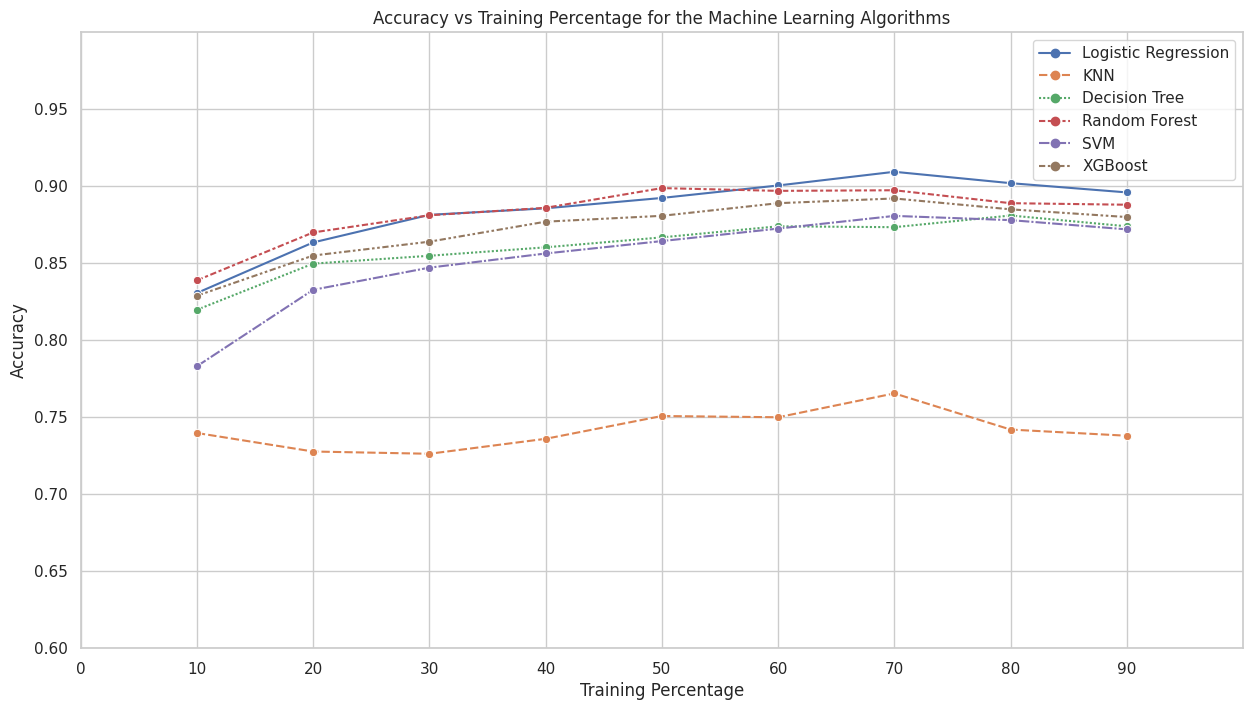

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = accuracies, markers= ['o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0.6,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0.6, 1, 0.05))
g.set_title("Accuracy vs Training Percentage for the Machine Learning Algorithms")
g.set_xlabel("Training Percentage")
g.set_ylabel("Accuracy")

<ipython-input-94-1b002271237c>:3: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  g = sns.lineplot(data = precisions, markers= ['o', 'o', 'o', 'o', 'o'])


Text(0, 0.5, 'Precision')

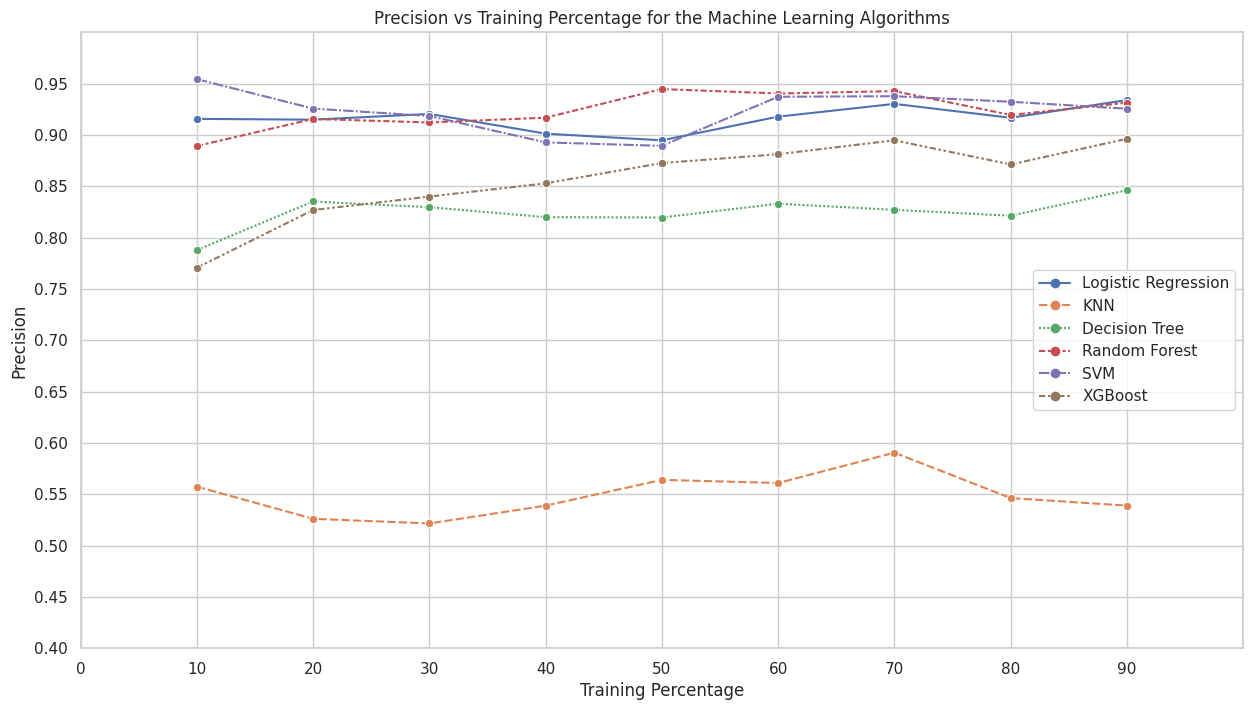

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = precisions, markers= ['o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0.4,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0.4, 1, 0.05))
g.set_title("Precision vs Training Percentage for the Machine Learning Algorithms")
g.set_xlabel("Training Percentage")
g.set_ylabel("Precision")

<ipython-input-95-db30ca728dcf>:3: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  g = sns.lineplot(data = recalls, markers= ['o', 'o', 'o', 'o', 'o'])


Text(0, 0.5, 'Recall')

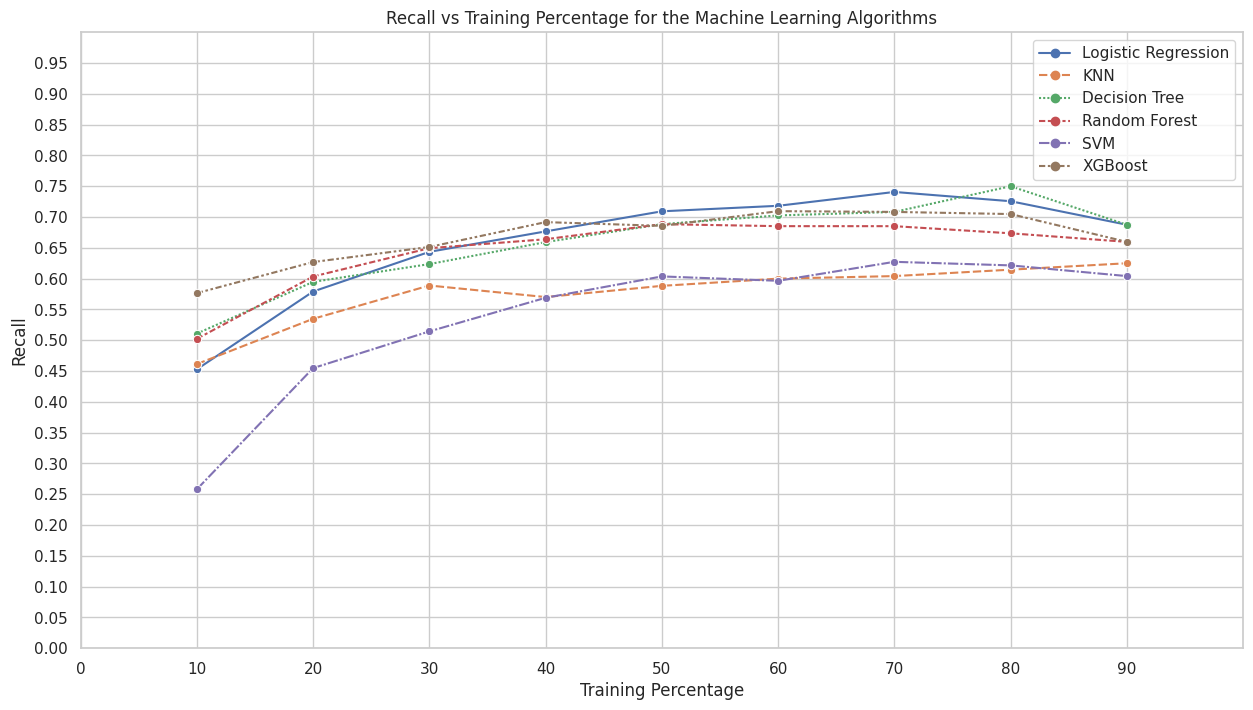

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = recalls, markers= ['o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0, 1, 0.05))
g.set_title("Recall vs Training Percentage for the Machine Learning Algorithms")
g.set_xlabel("Training Percentage")
g.set_ylabel("Recall")